In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json, pformat, pformat_vars
from itertools import product, combinations
# import pyperclip
import random
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater
# from causalbenchmark.novo.verbalization import misc
from causalbenchmark.novo import misc
from causalbenchmark.novo.verbalization.decision import Decision
from causalbenchmark.novo.templating import Template
from causalbenchmark.novo.verbalization import Verbalizer, MarginalVerbalization, ConditionalVerbalization
from causalbenchmark.novo.verbalization.variable import VariableVerbalization
from causalbenchmark.novo.verbalization.flavors import PrecisePercent
from causalbenchmark.novo.seeding.prompting import VerbalizationPrompting
from causalbenchmark.novo.simulation.solvers import ATE_Sign

In [2]:
path = misc.data_root() / 'stories'
story_names = [p.stem for p in path.glob('*.json')]#[:1]
print(story_names)

['China_2021_GDP_and_Inflation_Exploration', 'Comet Fragment Explosion Impact Analysis - Adriatic Coast', 'E-Bike Summer Sale Impact Analysis', 'Impact_of_Benelux_Tour_on_Tour_of_Britain_Performance', 'Impact_of_Covid_on_Auto_Industry_Job_Market', 'Impact_of_Refurbished_Tech_on_Student_Performance_Milan', 'Meteorite_Approach_Analysis_2024', 'NHS_Glasgow_Coronavirus_Outbreak_Impact_Study', 'Oil_Price_Trends_and_Global_Economic_Indicators_Analysis', 'Penguin_Populations_and_Climate_Change_Analysis', 'PlayStation_5_Supply_Demand_Analysis_Netherlands']


In [3]:
use_old_loading = False
# story_names = [
# 	# 'old/test19', 'old/test20', 'old/test21',
# 	# 'Facebook-WallStreet_Trends_Post-Verdict1',
# 	# 'RoyalFashionTrends_Analysis2',
# 	# 'EU Gas Alliance and Inflation Trends',
# 	
# 	'Impact_of_Covid_on_Auto_Industry_Job_Market',
# 	
# ]
stories = []
for name in story_names:
	story = Story(story_root=misc.data_root() / 'stories', story_id=name)#.populate_defaults()
	stories.append(story)
	if use_old_loading:
		story['stats'] = {int(k): v for k, v in story['stats'].items()}
		story['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in story['verbs'].items()}
		for k, v in story['verbs'].items():
			for k2, v2 in v.items():
				if 'value' in v2:
					v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
		story['questions']['questions'] = {int(k): v for k, v in story['questions']['questions'].items()}
len(stories)

In [4]:
def old_story_atoms(story):
	varverbs = {}
	for var, raw in story['verbs'].items():
		info = {'values': {0: {}, 1: {}}}
		
		info['variable'] = raw[1]['variable']
		info['subject'] = raw[2]['subject']
		info['domain'] = raw[4]['domain']
		
		for i in [0, 1]:
			info_val = info['values'][i]
			info_val['verb'] = raw[2]['value'][i] # goes with subject
			info_val['phrase'] = raw[3]['value'][i]
			info_val['descriptor'] = raw[4]['value'][i] # goes with domain
			info_val['event'] = raw[5]['value'][i]
			info_val['conditional'] = raw[6]['value'][i]
			info_val['interventional'] = raw[7]['value'][i]
			
		varverbs[var] = info
	
	story['sheet'] = varverbs
	return story

def story_atoms(story):
	base_keys = ['descriptor', 'subject', 'pronoun', 'preposition', 'domain']
	value_keys = ['predicate', 'nounclause', 'subclause', 'condition', 'action']
	verbs = []
	for node in story['nodes']:
		raw = story['verbs'][node['name']]
		info = {'values': {0: {}, 1: {}}}
		info.update({key: raw[key] for key in base_keys})
		for i in [0, 1]:
			info_val = info['values'][i]
			info_val.update({key: raw[f'{key}{i}'] for key in value_keys})
		# node['verbs'] = info
		verbs.append(info)
	story['verbs'] = verbs
for story in stories:
	(old_story_atoms if use_old_loading else story_atoms)(story)

In [15]:
story = random.choice(stories)
story = stories[-4]
# rawverbs = story['verbs']
# rawvars = {node['name']: node for node in story['nodes']}
# next(iter(rawverbs.values()))

In [16]:
node = random.choice(list(story['nodes']))
varval = 0
node['name'], node['values'][varval]

('Staff Stress Levels', 'High stress')

In [22]:
[node['name'] for node in story['nodes']]

['Prior Experience with Pandemics',
 'Hospital Funding',
 'PPE Availability',
 'Staff Training on Pandemic Protocols',
 'Staff Stress Levels',
 'Quality of Patient Care',
 'Staff Morale',
 'Staff Absenteeism']

In [17]:
def get_varverb(node, verb, varval, **static):
	varverb = VariableVerbalization().populate_defaults().populate_variable({**node, **static}, verb, varval)
	return varverb

def sample_text(ident=None, *other_tools, **static):
	if ident is None:
		ident = {}
	story_id = ident.setdefault('story_id', random.randint(0,len(stories)-1))
	story = stories[story_id]
	
	var_id = ident.setdefault('var_id', random.randint(0,len(story['nodes'])-1))
	varval = ident.setdefault('value_id', random.choice([0, 1]))
	
	varverb = get_varverb(story['nodes'][var_id], story['verbs'][var_id], varval, **static)

	conditions = []
	
	parent_ids = {key: val for key, val in sorted(ident.items()) if key.startswith('parent_id')}
	if len(parent_ids) or ident.setdefault('num_parents', random.choice([0, 1, 2])):
		parent_idx_options = [i for i, node in enumerate(story['nodes']) if i != var_id]
		if not len(parent_ids):
			num = ident.setdefault('num_parents', random.choice([0, 1, 2]))
			parent_ids = {f'parent_id{i}': pid for i, pid in enumerate(random.sample(parent_idx_options, k=num))}
		
		pvals = ident.setdefault('parent_vals', [random.randint(0, 1) for _ in range(len(parent_ids))])
		ident['parent_vals'] = tuple(pvals)
		conditions = [get_varverb(story['nodes'][pid], story['verbs'][pid], pval) 
					  for (key, pid), pval in zip(parent_ids.items(), pvals)]
		for k, pid in parent_ids.items():
			ident[k] = pid
	
	verbalizer = Verbalizer().populate_defaults().add_variable(varverb, *conditions)
	verbalizer.extend(other_tools)
	verbalizer.update(ident)
	return verbalizer

In [28]:
samples = []

prior = {
	'story_id': -4,
	'var_id': -3,
	# 'value_id': 0,
	
	# 'clause_id': 0,
	# 'position_id': 3,
	
	# 'num_parents': 0,
	'parent_id1': 3,
	# 'parent_vals': [1],
	# 'parent_id2': 1,
	
}

others = [PrecisePercent()]

for _ in range(30):
	ident = prior.copy()
	ctx = sample_text(ident, *others, mean=0.12)
	text = ctx['sentence']
	ident.update(ctx.identity())
	ctx['ident'] = ident
	samples.append(ctx)

cols = []
for row in samples:
	for key in row['ident']:
		if key not in cols:
			cols.append(key)

table = [(
	# i, len([k for k in row['ident'] if k not in prior]),
		  row['sentence'], 
		  # row['ctx']['event'], row['ctx']['event'], row['ctx']['phrase'], row['ctx']['subject'], row['ctx']['verb'],  
		  # *[row['ident'].get(key, '-') for key in cols]
		  ) for i, row in enumerate(samples)]
print(tabulate(table, headers=['i', 'dof', 'text', *cols]))# *list(map(str, range(len(cols))))]))

i
---------------------------------------------------------------------------------------------------------------------------------------------
Given that the staff lack adequate training for pandemics, the odds that the healthcare system maintains excellent care standards are 12%.
In 12% of medical facilities, patient treatment is not up to par, with comprehensive pandemic training.
If the staff are undertrained for pandemic scenarios, 12% of the time the quality of care is compromised.
12% of the time the healthcare system maintains excellent care standards, with comprehensive pandemic training.
Given that the staff lack adequate training for pandemics, with a certainty of 12%, a facility excels in patient care.
With comprehensive pandemic training, in 12% of medical facilities, care quality in a facility is lacking.
12% of the time the healthcare system provides subpar patient care, with comprehensive pandemic training.
Provided that there is thorough training in pandemic protocols,

In [19]:
sample = samples[0]
ident = sample['ident']
text = sample['sentence']

print(text)
print(ident)

If a cyclist manages to keep fatigue low and when a rider has less experience, 12% of the time the cyclist trains with low intensity.
{'story_id': 3, 'var_id': 4, 'value_id': 0, 'num_parents': 2, 'parent_vals': (0, 0), 'parent_id0': 5, 'parent_id1': 0, 'marginal_id': 2, 'antecedent_id': 0, 'conditional_id': 0, 'clause_id': 1, 'nounclause_id': 0}


In [ ]:

class ParentVerbalization(ToolKit):
	@tool('antecedent')
	def construct_antecedent(self, parents):
		pass


In [10]:
cond_templates = [
	['{antecedent}', '{clause}'],
	['{clause},', '{antecedent}'],
]

@tool('antecedent')
def construct_antecedent(parents):
	
	
	
	pass


In [60]:
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(story['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in story['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)

param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
net.set_params(param_sample)

In [61]:
treatments = [v['name'] for v in story['nodes'] if v['type'] == 'treatment']
outcome = [v['name'] for v in story['nodes'] if v['type'] == 'outcome'][0]
treatments, outcome

(['GDP Growth Rate', 'Inflation Rate'], 'Consumer Economic Confidence')

In [65]:
qid = random.randint(0, len(story['questions'])-1)
qid = 0
question = story['questions'][qid]
query = story['queries'][qid]
question, query

({'question': 'Does a higher GDP growth rate generally lead to better overall economic outcomes?',
  'answer': 'yes',
  'explanation': 'A higher GDP growth rate typically results in more positive economic outcomes.'},
 {'treatment': 'GDP Growth Rate',
  'query': 'ate',
  'type': 'ate-sign',
  'criterion': '>'})

In [74]:
solver = ATE_Sign(net)
sol = Context().include(solver)
sol['outcome'] = outcome
sol.update(**query)
sol

Context(outcome, treatment, query, type, criterion, {estimand}, {conditions}, {terms}, {values}, {estimate}, {ate}, {ground_truth})

In [67]:
sol['estimand']

('GDP Growth Rate', 'Consumer Economic Confidence', ['Inflation Rate'])

In [68]:
sol['terms']

[('Inflation Rate', {}),
 ('Consumer Economic Confidence', {'GDP Growth Rate': 0, 'Inflation Rate': 0}),
 ('Consumer Economic Confidence', {'GDP Growth Rate': 0, 'Inflation Rate': 1}),
 ('Consumer Economic Confidence', {'GDP Growth Rate': 1, 'Inflation Rate': 0}),
 ('Consumer Economic Confidence', {'GDP Growth Rate': 1, 'Inflation Rate': 1})]

In [76]:
sol['ate']

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [75]:
sol['estimate']

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


ValueError: Could not save to JPEG for display

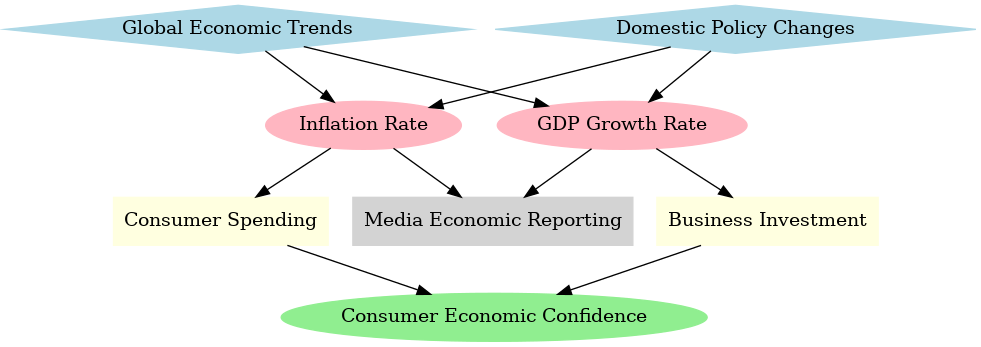

In [80]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in story['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in story['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [32]:
net.ate(query['treatment'], conditions={query['confounder']: query['confounder_value']})[outcome]

tensor(0.0290)

In [ ]:
net.ate(query['treatment'], conditions={query['confounder']: query['confounder_value']})[outcome]

In [42]:
print(VerbalizationPrompting().get_query_descriptions(story['queries']))

	1. ATE('Meteorite Visibility') < 0
	2. ATE('NASA Communication') < 0
	3. ATE('Meteorite Visibility') > ATE('NASA Communication')
	4. |ATE('Meteorite Visibility')| < |ATE('NASA Communication')|
	5. CATE('Meteorite Visibility' | 'Media Coverage' = 0) < 0
	6. CATE('NASA Communication' | 'Media Coverage' = 0) < 0
	7. CATE('Meteorite Visibility' | 'Media Coverage' = 0) > CATE('NASA Communication' | 'Media Coverage' = 0)
	8. |CATE('NASA Communication' | 'Media Coverage' = 0)| < |CATE('Meteorite Visibility' | 'Media Coverage' = 0)|
	9. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < 0
	10. CATE('NASA Communication' | 'Media Coverage' = 1) < 0
	11. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < CATE('NASA Communication' | 'Media Coverage' = 1)
	12. |CATE('NASA Communication' | 'Media Coverage' = 1)| > |CATE('Meteorite Visibility' | 'Media Coverage' = 1)|
	13. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < CATE('Meteorite Visibility' | 'Media Coverage' = 0)
	14. |CATE('Mete

In [ ]:
ident = {}
ctx = sample_text(ident, mean=0.57)



text = Template.detok(ctx['clause'], capitalize=True, sentence=True)
ident.update(ctx.identity())
print(text)
ident

In [33]:

selection = {}




story = random.choice(stories)
varname = random.choice(list(rawverbs.keys()))
varinfo = story['sheet'][varname]
varval = 0

ctx = ClauseVerbalization().populate_variable_info(info, mean=0.57).populate_default(precise_templates=precise_templates, position_templates=position_templates)

# ctx['clause_id'] = 3
ctx['position_id'] = 0

text = Template.detok(ctx['clause'], capitalize=True, sentence=True)
print(text)
ctx.identity()

The chance that this incident was scarcely covered by the media is 57%.


{'verb_id': 1, 'clause_id': 1, 'position_id': 0, 'chance_word_id': 1}

In [10]:
# ClauseVerbalization._precise_templates[0]

In [8]:

prob_words = ['probability', 'chance', 'likelihood']
chance_words = ['probability', 'chance', 'likelihood', 'odds']



In [18]:
def detok(tokens):
	toks = [', ' if tok == ',' else tok for tok in tokens]
	sentence = ' '.join(toks) + '.'
	return sentence.capitalize()

In [ ]:
# 1. One of the variables is {descriptor}.
# 2. {subject} [often/usually/sometimes/rarely/etc.] {predicate}.
# 3. There is a [number]% chance that {noun-clause}.
# 4. [In/For/With/etc.] [number]% of {domain}, there {phrase}.
# 5. Conditional sentence: {condition}, [some consequence].
# 6. Interventional: If {action}, [some effect].

In [19]:
# The man that she loved went home.
# She realized that he loves her.

NameError: name 'AbstractGadget' is not defined

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].